IN THIS FILE WE'LL BE FOCUSING ON FINALISING THE NUMBER OF CLUSTERS, TRAINING THE FINAL MODEL FOR CUSTOMER SEGMENTATION AND SAVING THEM FOR STREAMLIT INTEGRATION.

In [2]:
# Importing the dependencies
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

1. Loading the rfm dataframe.

In [3]:
rfm = pd.read_csv('../data/rfm_features.csv')

# Display the first few rows of the RFM features DataFrame
print(rfm.head())

   CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12347       40          7   4310.00
2       12348       76          4   1797.24
3       12349       19          1   1757.55
4       12350      311          1    334.40


2. Scaling the features of rfm dataframe.

In [4]:
# Importing the library
from sklearn.preprocessing import StandardScaler

# Selecting only the RFM features for scaling
x= rfm[['Recency', 'Frequency', 'Monetary']]

# Initializing the scaler
scaler = StandardScaler()

# Fitting and transforming the data
x_scaled = scaler.fit_transform(x)

3. Elbow Curve Analysis.

In [5]:
# Importing the library for KMeans
from sklearn.cluster import KMeans

# Building and training the KMeans model
inertia = []
K = range(1, 11)
for k in K:
    elbow = KMeans(n_clusters=k, random_state=42)
    elbow.fit(x_scaled)
    inertia.append(elbow.inertia_)

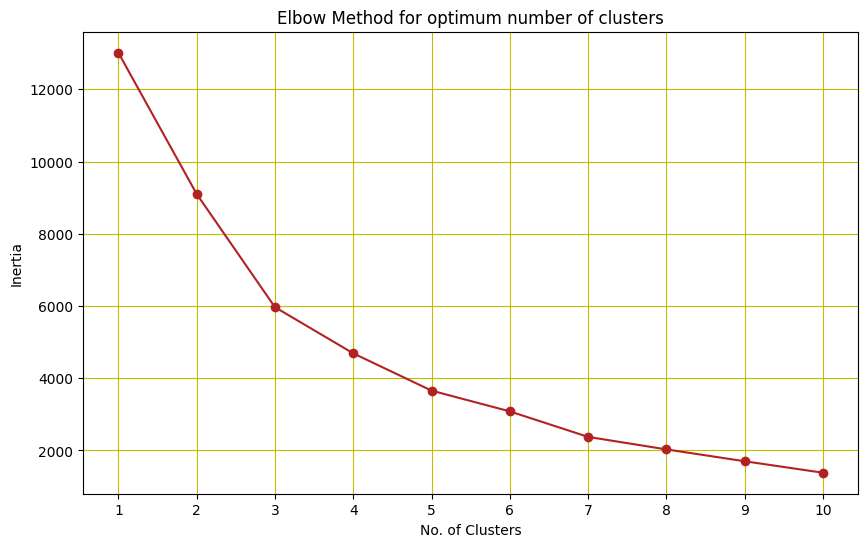

In [6]:
# Plotting the Elbow curve graph
plt.figure(figsize=(10,6))
plt.plot(K, inertia, marker='o', color='firebrick')
plt.grid(color='y')
plt.title('Elbow Method for optimum number of clusters')
plt.xlabel('No. of Clusters')
plt.ylabel('Inertia')
plt.xticks(K)
plt.show()

Insights-
- From the above graph, we see that a sharp reduction in inertia is seen upto 4 clusters, after which the rate of improvement decreases.
- This indicates that 4 clusters provide a good balance for interpreting customer segmentation.

4. Silhouette Score Analysis.

In [7]:
# Importing the library for Silhouette Score
from sklearn.metrics import silhouette_score

# Building and training the model
silhouette_scores = []
Ks = range(2, 11)
for ks in Ks:
    silhouette = KMeans(n_clusters=ks, random_state=42)
    cluster_labels = silhouette.fit_predict(x_scaled)
    score = silhouette_score(x_scaled, cluster_labels)
    silhouette_scores.append(score)

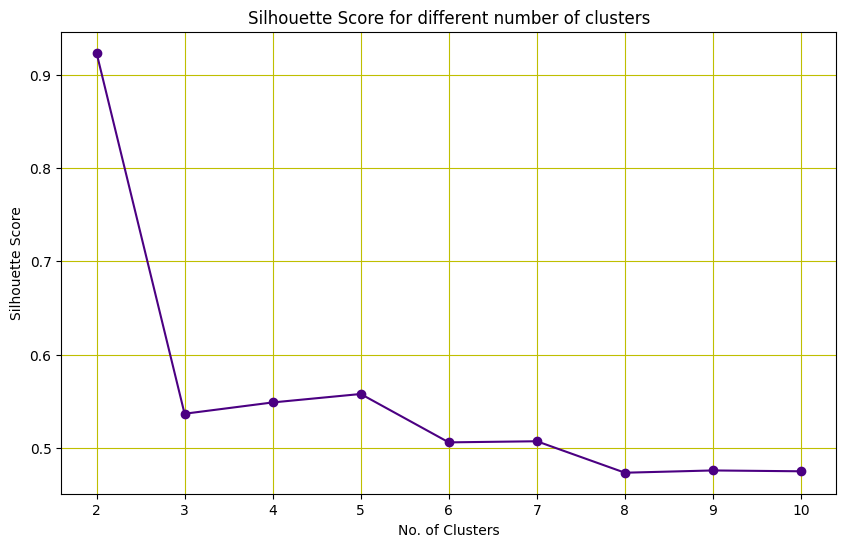

In [8]:
# Plotting the Silhouette Score graph
plt.figure(figsize=(10,6))
plt.plot(Ks, silhouette_scores, marker='o', color='indigo')
plt.grid(color='y')
plt.title('Silhouette Score for different number of clusters')
plt.xlabel('No. of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(Ks)
plt.show()

Insights-
- Although 2 clusters give the highest silhouette score, but this produces overly broad customer groups (likely high value/low value).
- So, 4 clusters were chosen to achieve more meaningful customer segmentation.

5. Building and training the final KMeans model.

In [9]:
# Initialising the KMeans model with the optimal number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)

# Fitting the model
kmeans.fit(x_scaled)

# Assigning the cluster labels
rfm['Cluster'] = kmeans.labels_

In [10]:
# Checking few rows of the rfm dataframe
rfm.sample(8)

,CustomerID,Recency,Frequency,Monetary,Cluster
3639,17337,4,4,1981.06,0
2847,16221,98,3,860.86,0
3734,17457,205,5,1737.70,2
2884,16275,197,1,559.87,2
3196,16713,6,15,6910.78,0
2918,16327,15,6,3820.27,0
1761,14745,113,5,1220.26,0
1591,14512,218,2,275.28,2


6. Computing Cluster-wise RFM averages.

In [11]:
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print(cluster_profile)

   Cluster     Recency  Frequency       Monetary
0        0   47.921431   4.717023    1879.798244
1        1   21.200000  76.400000  209287.556000
2        2  261.061277   1.553191     502.628946
3        3   23.629630  57.629630   50538.288889


So, from the above table we can clearly differentiate as to which cluster belongs to which segment:
- 0: The customers belonging to this cluster fall under the "Occasional" category, since they have medium recency, medium frequency (not making purchases very often) and medium monetary value.

- 1: The customers that come under this cluster are labelled, "High-Value", since they have very low recency (that is they made a purchase recently), high frequency and very high monetary value.

- 2: These customers come under the segment of "At-Risk", since they have a high recency, which shows that they have been inactive for a long time, low frequency and low monetary value.

- 3: These customers belong to the "Regular" segment as they show low recency, high frequency and high monetary value.

In [20]:
# Creating a mapping of cluster numbers to labels, as per the observations
cluster_label = {
    0: 'Occasional',
    1: 'High-Value',
    2: 'At-Risk',
    3: 'Regular'}

# Mapping the cluster numbers to labels
rfm['Segment'] = rfm['Cluster'].map(cluster_label)

7. Visualising Customer Segments.

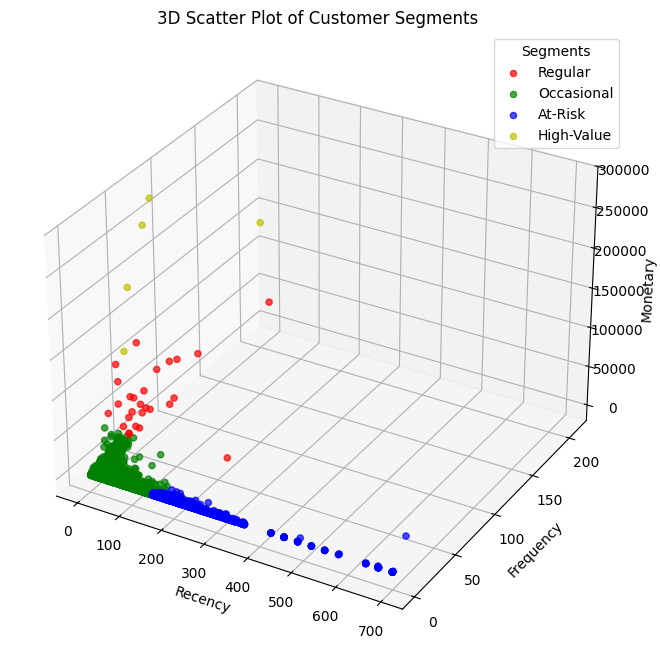

In [ ]:
# Creating a 3D scatter plot to visualize the clusters
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

segments = rfm['Segment'].unique()
colors = ['r', 'g', 'b', 'y']
for segment, color in zip(segments, colors):
    subset = rfm[rfm['Segment'] == segment]
    scatter = ax.scatter(
        subset['Recency'],
        subset['Frequency'],
        subset['Monetary'],
        label=segment,
        color=color,
        alpha=0.7
    )

ax.set_title('3D Scatter Plot of Customer Segments')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.legend(title='Segments')
plt.show()

8. Saving the trained model, scaler and the cluster label mapping.

In [22]:
import joblib
import os

# Creating directory to save the model and scaler if it doesn't exist
os.makedirs('../data/artifacts_model', exist_ok=True)

# Saving the trained KMeans model
joblib.dump(kmeans, '../data/artifacts_model/kmeans_model.pkl')

# Saving the scaler
joblib.dump(scaler, '../data/artifacts_model/rfm_scaler.pkl')

# Saving the mapping of cluster numbers to labels
joblib.dump(cluster_label, '../data/artifacts_model/cluster_label_mapping.pkl')

['../data/artifacts_model/cluster_label_mapping.pkl']